## Exercise 1

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sg

# Parameters
N = 513
fs = 5000
fc = 20
df = 70
freq_point_num = 5000

# Convert to digital frequency (radians/sample)
wc = 2 * np.pi * fc / fs
dw = 2 * np.pi * df / fs
frequencies = np.linspace(-np.pi, np.pi, freq_point_num)

# Desired frequency response
desired = np.zeros(freq_point_num)
for i in range(freq_point_num):
    w = frequencies[i]
    if -dw - wc <= w < -wc:
        desired[i] = (1 / dw) * w + (1 + wc / dw)
    elif -wc <= w <= wc:
        desired[i] = 1
    elif wc < w <= wc + dw:
        desired[i] = (-1 / dw) * w + (1 + wc / dw)

# Cosine matrix
A = np.zeros((freq_point_num, N // 2), dtype=complex)
for i in range(freq_point_num):
    for j in range(N // 2):
        A[i, j] = 1 if j == 0 else 2 * np.cos(frequencies[i] * j)

# Solve using least squares
taps_2 = np.linalg.pinv(A) @ desired
taps = np.concatenate((np.flip(taps_2[1:]), taps_2))


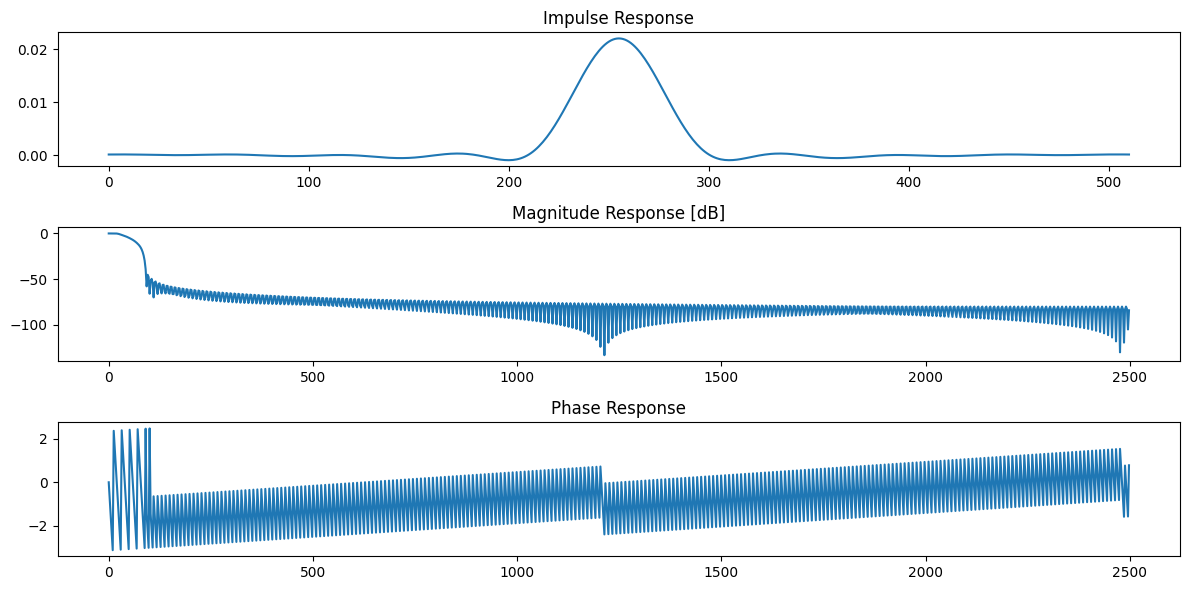

In [11]:
w, H = sg.freqz(taps, worN=1024, fs=fs)

plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.plot(taps)
plt.title("Impulse Response")

plt.subplot(3, 1, 2)
plt.plot(w, 20 * np.log10(np.abs(H)))
plt.title("Magnitude Response [dB]")

plt.subplot(3, 1, 3)
plt.plot(w, np.angle(H))
plt.title("Phase Response")

plt.tight_layout()
plt.show()


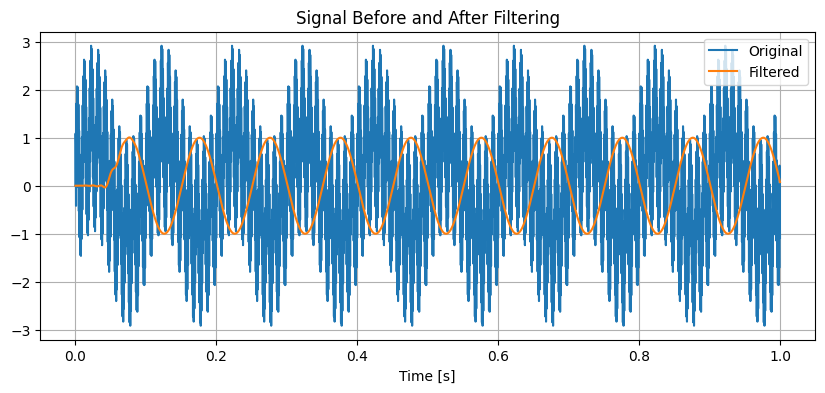

In [12]:
t = np.linspace(0, 1, fs, endpoint=False)
x = np.sin(2*np.pi*10*t) + np.sin(2*np.pi*100*t) + np.sin(2*np.pi*1000*t)
y = sg.lfilter(taps, 1.0, x)

# Plot result
plt.figure(figsize=(10, 4))
plt.plot(t, x, label="Original")
plt.plot(t, y, label="Filtered")
plt.legend()
plt.title("Signal Before and After Filtering")
plt.xlabel("Time [s]")
plt.grid()
plt.show()


## Exercise 2

In [13]:
import scipy.optimize as opt

fc = 800
numtaps = 61
freq_grid = np.linspace(0, np.pi, 1024)
desired_freq_response = np.zeros_like(freq_grid)
desired_freq_response[freq_grid <= (2*np.pi*fc/fs)] = 1

def make_objective(Lp_norm):
    def objective(h):
        w, H = sg.freqz(h, worN=freq_grid, whole=True)
        return np.linalg.norm(np.abs(H) - desired_freq_response, ord=Lp_norm)
    return objective

# Initial guess (sinc)
h0 = np.sinc(2 * fc * (np.arange(numtaps) - (numtaps - 1) / 2) / fs)

results = {}
for p in [2, 1, np.inf]:
    res = opt.minimize(make_objective(p), h0, method='L-BFGS-B', tol=1e-6, options={'maxiter': 500})
    results[f"L{p}"] = res.x


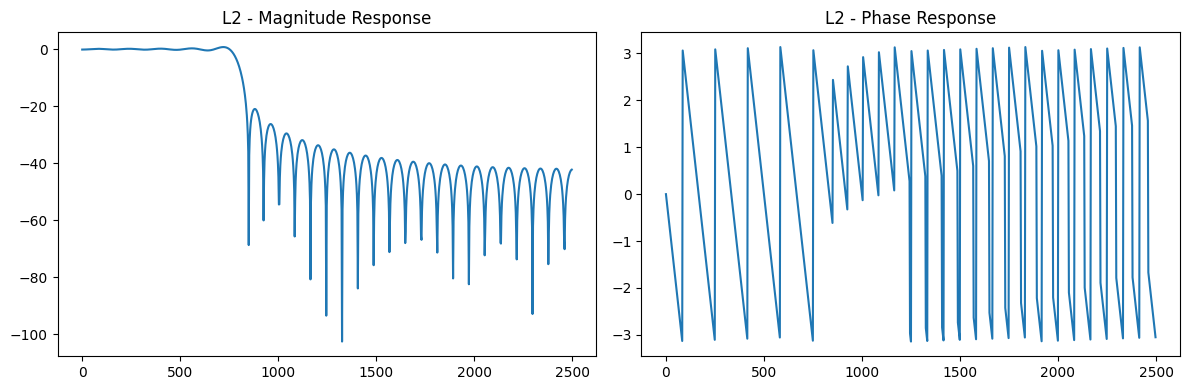

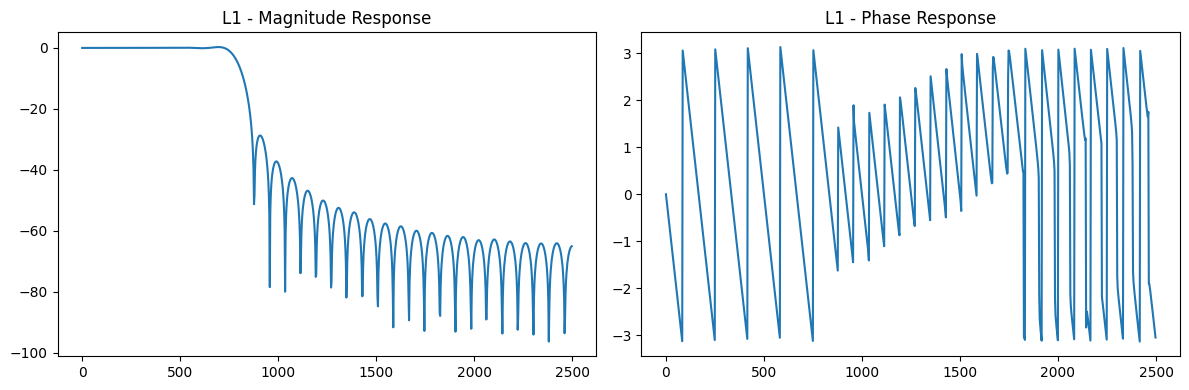

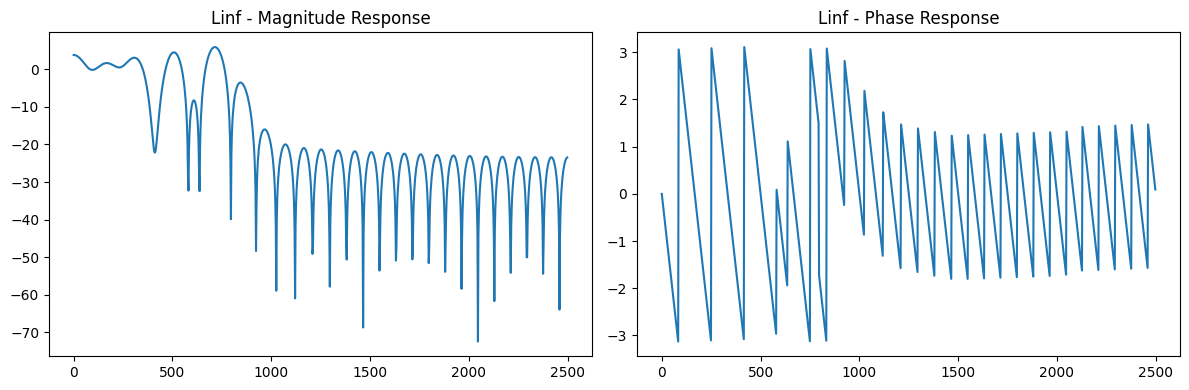

In [14]:
for key, h in results.items():
    w, H = sg.freqz(h, worN=1024, fs=fs)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(w, 20 * np.log10(np.abs(H)))
    plt.title(f"{key} - Magnitude Response")
    plt.subplot(1, 2, 2)
    plt.plot(w, np.angle(H))
    plt.title(f"{key} - Phase Response")
    plt.tight_layout()
    plt.show()


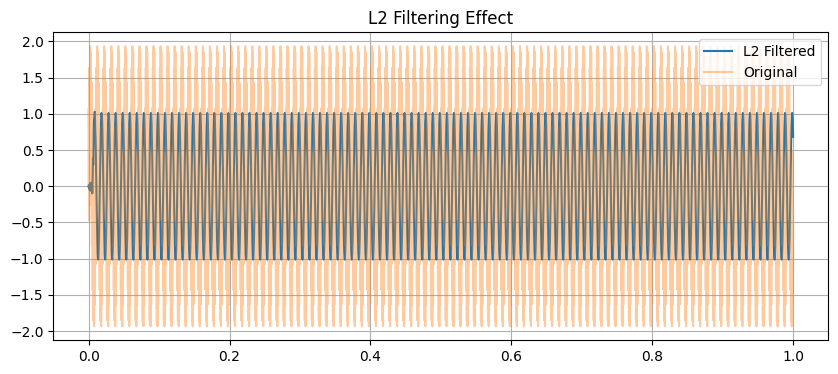

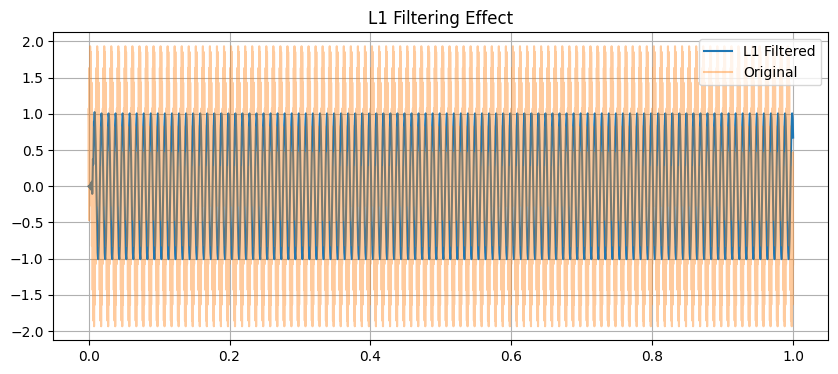

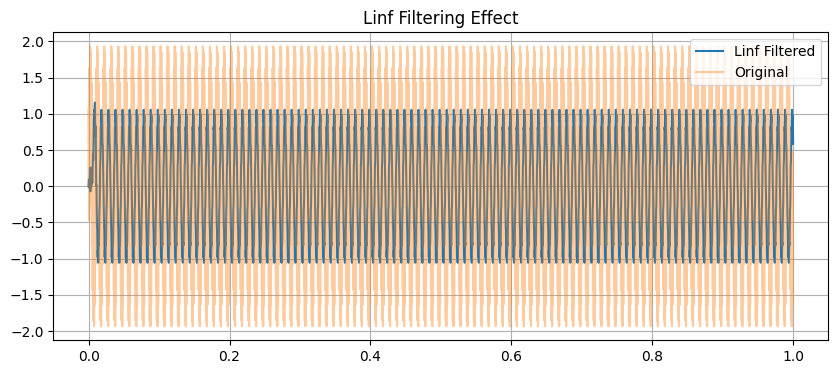

In [15]:
x = np.sin(2*np.pi*100*t) + np.sin(2*np.pi*1000*t)

for key, h in results.items():
    y = sg.lfilter(h, 1.0, x)
    plt.figure(figsize=(10, 4))
    plt.plot(t, y, label=f"{key} Filtered")
    plt.plot(t, x, alpha=0.4, label="Original")
    plt.title(f"{key} Filtering Effect")
    plt.legend()
    plt.grid()
    plt.show()


In [16]:
W = np.ones_like(freq_grid)
# 0 in transition band
W[(freq_grid > 2*np.pi*700/fs) & (freq_grid < 2*np.pi*900/fs)] = 0
# 0.5 in passband and stopband
W[W == 1] = 0.5

def weighted_objective(h):
    w, H = sg.freqz(h, worN=freq_grid, whole=True)
    return np.linalg.norm(W * (np.abs(H) - desired_freq_response))


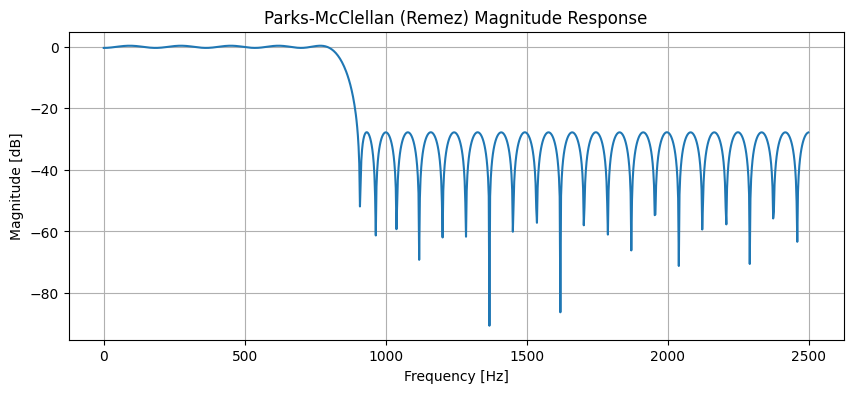

In [17]:
h_remez = sg.remez(61, [0, 800, 900, fs//2], [1, 0], fs=fs)
w, H = sg.freqz(h_remez, worN=1024, fs=fs)

plt.figure(figsize=(10, 4))
plt.plot(w, 20*np.log10(np.abs(H)))
plt.title("Parks-McClellan (Remez) Magnitude Response")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude [dB]")
plt.grid()
plt.show()
